# Lecture 4

Statistical Rethinking Winter 2022 lecture 4. The slide numbers are in reference to [this link](https://speakerdeck.com/rmcelreath/statistical-rethinking-2022-lecture-04).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

In [5]:
df_howell = pd.read_csv("../Data/Howell1.csv", sep=";", header=0)
# limit to adults
df_howell_ad = df_howell[df_howell["age"] >= 18].copy()
df_howell_ad.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [6]:
heights = df_howell_ad["height"].values
h_bar = df_howell_ad["height"].mean()
s_index = df_howell_ad["male"].values
weights = df_howell_ad["weight"].values

# Slide 26

$$ W_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{S[i]}$$
$$ \alpha_j \sim \text{Normal}(60, 10) $$
$$ \sigma \sim \text{Uniform}(0, 10) $$

In [7]:
with pm.Model() as m_SW:

    # priors
    a = pm.Normal("a", 60, 10, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)

    mu = a[s_index]  # linear model
    W = pm.Normal("W", mu, sigma, observed=weights)  # likelihood

    # posterior
    idata_m_SW = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


KeyboardInterrupt: 

In [10]:
az.summary(idata_m_SW)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],41.845,0.397,41.241,42.503,0.005,0.004,5449.0,3282.0,1.0
a[1],48.603,0.436,47.908,49.286,0.006,0.004,5551.0,2910.0,1.0
sigma,5.522,0.205,5.189,5.838,0.003,0.002,6015.0,2924.0,1.0


<IPython.core.display.Javascript object>

# Slides 27 and 28

In [11]:
idata_m_SW_df = idata_m_SW.to_dataframe()
idata_m_SW_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, sigma)","(log_likelihood, W[0], 0)","(log_likelihood, W[100], 100)","(log_likelihood, W[101], 101)","(log_likelihood, W[102], 102)","(log_likelihood, W[103], 103)",...,"(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, lp)","(sample_stats, index_in_trajectory)","(sample_stats, energy_error)","(sample_stats, perf_counter_start)","(sample_stats, step_size)","(sample_stats, energy)","(sample_stats, largest_eigval)","(sample_stats, perf_counter_diff)"
0,0,0,42.256828,48.269248,5.407698,-2.610127,-2.618600,-2.848256,-3.582228,-4.864629,...,False,0.391595,-1109.972620,-3,-0.004403,211895.148179,1.031246,1111.432725,NaN,0.000538
1,0,1,42.170727,49.094724,5.688638,-2.682296,-2.657410,-2.865755,-3.559117,-4.415164,...,False,0.201964,-1110.360991,-2,0.112085,211895.148840,1.031246,1111.373760,NaN,0.000530
2,0,2,41.925625,48.973739,5.428835,-2.633027,-2.610939,-2.809907,-3.665291,-4.584715,...,False,-0.244023,-1109.449813,1,-0.244023,211895.149515,1.031246,1110.312046,NaN,0.000905
3,0,3,41.790876,48.253189,5.666450,-2.656348,-2.664703,-2.822287,-3.654906,-4.715623,...,False,0.338585,-1109.711563,3,0.107409,211895.150545,1.031246,1110.995566,NaN,0.000530
4,0,4,41.935076,48.848677,5.693528,-2.674413,-2.659253,-2.840418,-3.614819,-4.494897,...,False,0.602582,-1109.647795,-3,0.041269,211895.151198,1.031246,1112.040996,NaN,0.000523


<IPython.core.display.Javascript object>

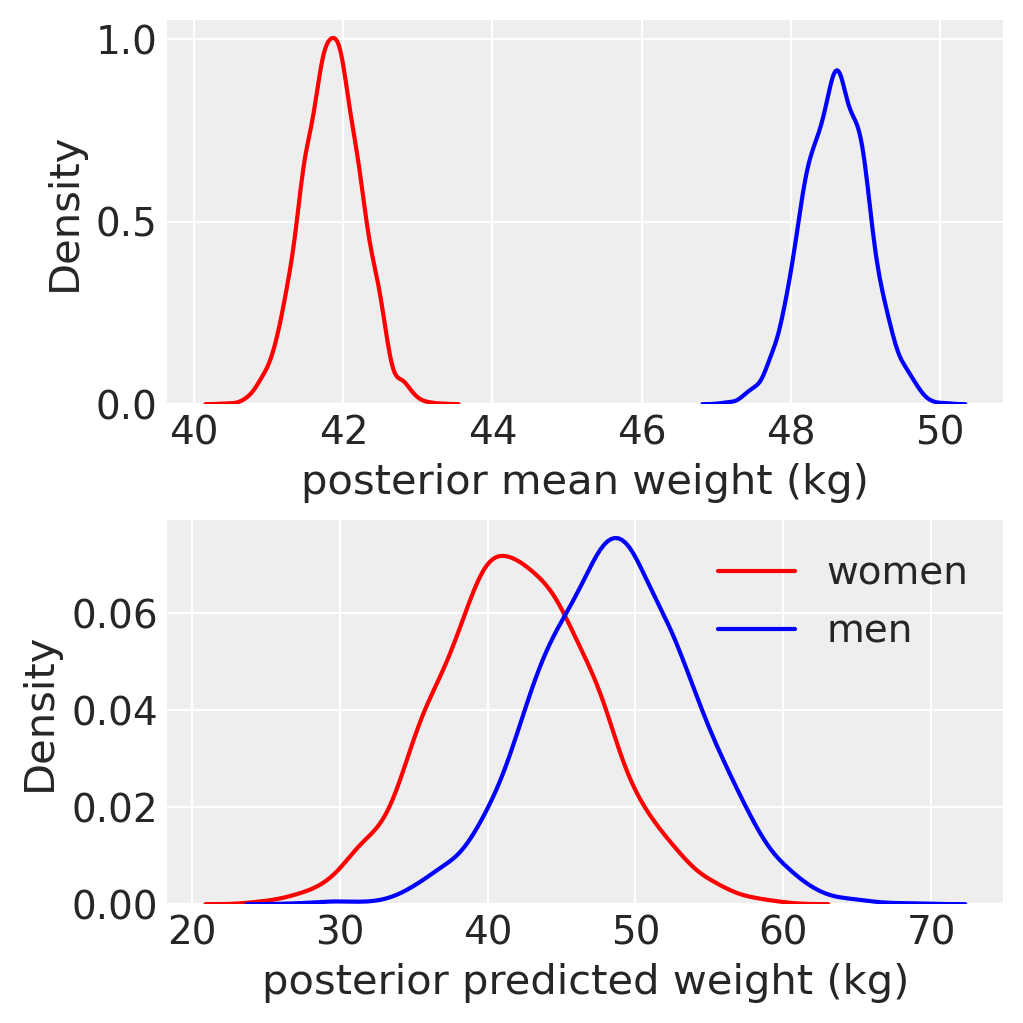

<IPython.core.display.Javascript object>

In [12]:
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 5))

# Plot of contrast using distribution of mean only  ---------
sns.kdeplot(idata_m_SW_df[("posterior", "a[0]", 0)], color="red", ax=ax0)
sns.kdeplot(idata_m_SW_df[("posterior", "a[1]", 1)], color="blue", ax=ax0)
ax0.set(xlabel="posterior mean weight (kg)")

# # Plot of contrast using full posterior distribution ---------
W0 = stats.norm.rvs(
    loc=idata_m_SW_df[("posterior", "a[0]", 0)],
    scale=idata_m_SW_df[("posterior", "sigma")],
    # size=n   (*see note below)
)

W1 = stats.norm.rvs(
    loc=idata_m_SW_df[("posterior", "a[1]", 1)],
    scale=idata_m_SW_df[("posterior", "sigma")],
)

sns.kdeplot(W0, color="red", label="women", ax=ax1)
sns.kdeplot(W1, color="blue", label="men", ax=ax1)
ax1.set(xlabel="posterior predicted weight (kg)")
ax1.legend()

# *unlike in R, size has to be the same as the length of the vectors

# Slide 32

In [13]:
mu_contrast = idata_m_SW_df[("posterior", "a[1]", 1)] - idata_m_SW_df[("posterior", "a[0]", 0)]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'posterior mean weight contrast (kg)'), (3.0, 10.0)]

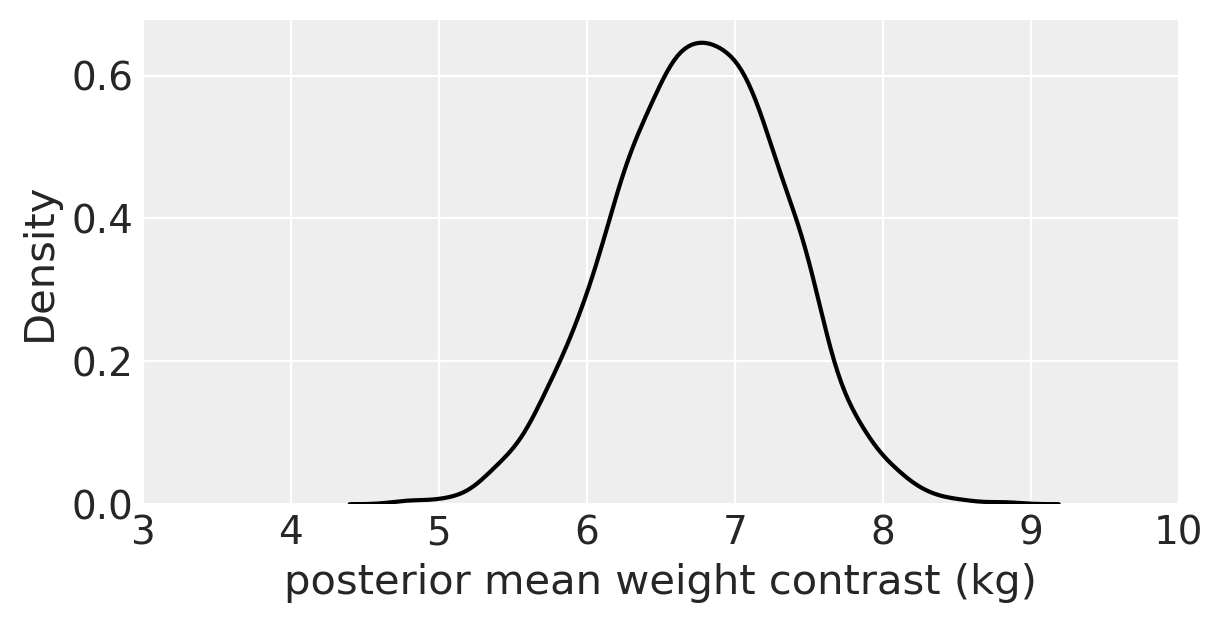

<IPython.core.display.Javascript object>

In [21]:
f, ax0 = plt.subplots(figsize=(6, 3))
sns.kdeplot(mu_contrast, color="black", ax=ax0)
ax0.set(xlabel="posterior mean weight contrast (kg)", xlim=[3, 10])

# Slide 33

Proportion above zero: 0.8065
Proportion below zero: 0.1935


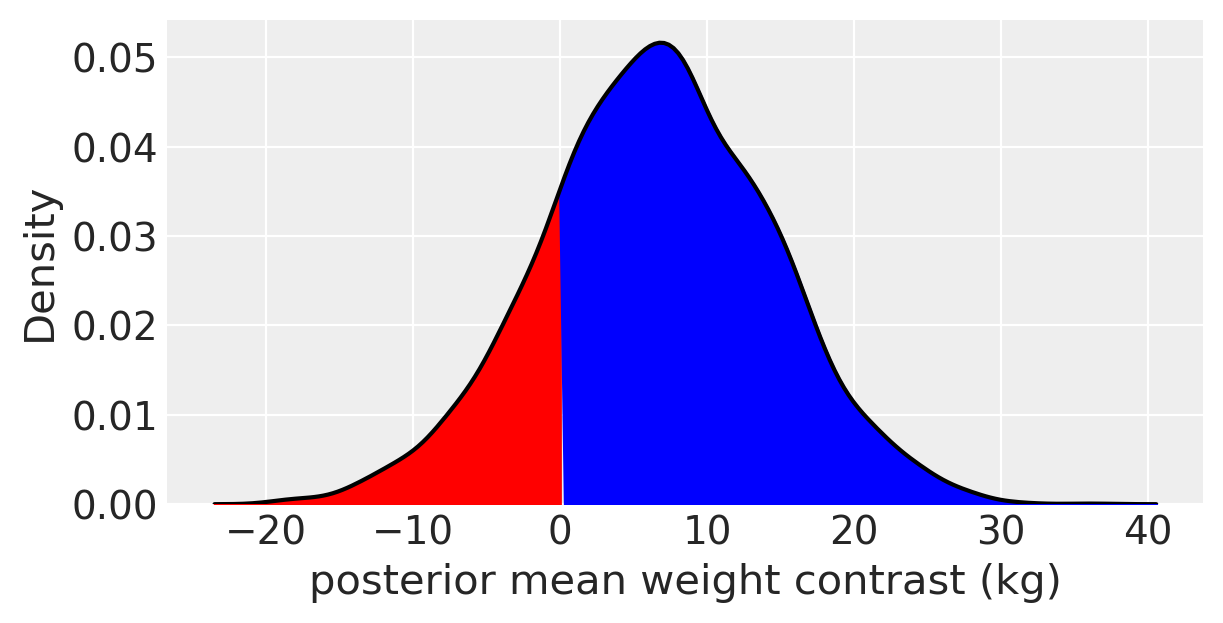

<IPython.core.display.Javascript object>

In [35]:
# posterior W distributions
W0 = stats.norm.rvs(idata_m_SW_df[("posterior", "a[0]", 0)], idata_m_SW_df[("posterior", "sigma")])
W1 = stats.norm.rvs(idata_m_SW_df[("posterior", "a[1]", 1)], idata_m_SW_df[("posterior", "sigma")])

# contrast
W_contrast = W1 - W0

f, ax0 = plt.subplots(figsize=(6, 3))
sns.kdeplot(W_contrast, color="black", ax=ax0)
kde_x, kde_y = ax0.lines[0].get_data()
ax0.fill_between(kde_x, kde_y, where=kde_x < 0, color="red", interpolate=True)
ax0.fill_between(kde_x, kde_y, where=kde_x > 0, color="blue", interpolate=True)
ax0.set(xlabel="posterior mean weight contrast (kg)")

# proportion above zero
print(f"Proportion above zero: {sum( W_contrast > 0 ) / len(W_contrast)}")
# proportion below zero
print(f"Proportion below zero: {sum( W_contrast < 0 ) / len(W_contrast)}")

# Slide 39

"One stat model for each estimand"

$$ W_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{S[i]} + \beta_{S[i]}(H_i - \bar{H}) $$
$$ \alpha_j \sim \text{Normal}(60, 10) $$
$$ \beta_j \sim \text{LogNormal}(0, 1) $$
$$ \sigma \sim \text{Uniform}(0, 10) $$

In [36]:
with pm.Model() as m_SHW:

    # priors
    a = pm.Normal("a", 60, 10, shape=2)
    b = pm.Lognormal("b", 0, 1, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)

    mu = a[s_index] + b[s_index] * (heights - h_bar)  # linear model
    W = pm.Normal("W", mu, sigma, observed=weights)  # likelihood

    # posterior
    idata_m_SHW = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


<IPython.core.display.Javascript object>

In [37]:
az.summary(idata_m_SHW)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.162,0.444,44.471,45.892,0.008,0.006,2763.0,2926.0,1.0
a[1],45.087,0.443,44.405,45.839,0.008,0.005,3334.0,2904.0,1.0
b[0],0.657,0.062,0.562,0.757,0.001,0.001,2803.0,2647.0,1.0
b[1],0.611,0.053,0.528,0.696,0.001,0.001,3293.0,2541.0,1.0
sigma,4.264,0.162,4.009,4.531,0.003,0.002,3527.0,2970.0,1.0


<IPython.core.display.Javascript object>

In [42]:
idata_m_SHW_df = idata_m_SHW.to_dataframe()
idata_m_SHW_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, b[0], 0)","(posterior, b[1], 1)","(posterior, sigma)","(log_likelihood, W[0], 0)","(log_likelihood, W[100], 100)","(log_likelihood, W[101], 101)",...,"(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, lp)","(sample_stats, index_in_trajectory)","(sample_stats, energy_error)","(sample_stats, perf_counter_start)","(sample_stats, step_size)","(sample_stats, energy)","(sample_stats, largest_eigval)","(sample_stats, perf_counter_diff)"
0,0,0,44.784003,45.729679,0.578573,0.528648,4.232684,-2.722087,-2.400215,-2.872876,...,False,0.922296,-1021.389847,-2,0.297635,213263.509980,0.633598,1023.325245,NaN,0.001416
1,0,1,44.622343,45.532396,0.611098,0.547969,4.040864,-2.768127,-2.355364,-2.806559,...,False,0.146242,-1021.611949,2,0.105012,213263.511557,0.633598,1022.688147,NaN,0.001402
2,0,2,44.848028,45.862641,0.599692,0.561718,4.159105,-2.709292,-2.417396,-2.871312,...,False,3.042062,-1021.363578,2,0.284299,213263.513117,0.633598,1026.409075,NaN,0.001402
3,0,3,44.796126,45.707281,0.653227,0.574829,4.155293,-2.749737,-2.412738,-2.814255,...,False,-0.229344,-1020.949977,-1,0.071866,213263.514678,0.633598,1022.072411,NaN,0.000730
4,0,4,45.555690,44.654870,0.756849,0.702435,4.265313,-3.101240,-2.439198,-2.909542,...,False,0.139567,-1021.660764,-4,0.139567,213263.515563,0.633598,1023.162183,NaN,0.001412


<IPython.core.display.Javascript object>

# Slide 41

In [68]:
xseq = np.linspace(130, 190, num=50)

<IPython.core.display.Javascript object>

In [45]:
# initialize dataframes
muF = np.zeros((len(idata_m_SHW_df), len(xseq)))
muM = np.zeros((len(idata_m_SHW_df), len(xseq)))

<IPython.core.display.Javascript object>

In [46]:
idata_m_SHW_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, b[0], 0)","(posterior, b[1], 1)","(posterior, sigma)","(log_likelihood, W[0], 0)","(log_likelihood, W[100], 100)","(log_likelihood, W[101], 101)",...,"(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, lp)","(sample_stats, index_in_trajectory)","(sample_stats, energy_error)","(sample_stats, perf_counter_start)","(sample_stats, step_size)","(sample_stats, energy)","(sample_stats, largest_eigval)","(sample_stats, perf_counter_diff)"
0,0,0,44.784003,45.729679,0.578573,0.528648,4.232684,-2.722087,-2.400215,-2.872876,...,False,0.922296,-1021.389847,-2,0.297635,213263.509980,0.633598,1023.325245,NaN,0.001416
1,0,1,44.622343,45.532396,0.611098,0.547969,4.040864,-2.768127,-2.355364,-2.806559,...,False,0.146242,-1021.611949,2,0.105012,213263.511557,0.633598,1022.688147,NaN,0.001402
2,0,2,44.848028,45.862641,0.599692,0.561718,4.159105,-2.709292,-2.417396,-2.871312,...,False,3.042062,-1021.363578,2,0.284299,213263.513117,0.633598,1026.409075,NaN,0.001402
3,0,3,44.796126,45.707281,0.653227,0.574829,4.155293,-2.749737,-2.412738,-2.814255,...,False,-0.229344,-1020.949977,-1,0.071866,213263.514678,0.633598,1022.072411,NaN,0.000730
4,0,4,45.555690,44.654870,0.756849,0.702435,4.265313,-3.101240,-2.439198,-2.909542,...,False,0.139567,-1021.660764,-4,0.139567,213263.515563,0.633598,1023.162183,NaN,0.001412


<IPython.core.display.Javascript object>

In [50]:
# Fill female and male predictions
for i, x in enumerate(xseq):
    muF[:, i] = idata_m_SHW_df[("posterior", "a[0]", 0)] + idata_m_SHW_df[
        ("posterior", "b[0]", 0)
    ] * (x - h_bar)
    muM[:, i] = idata_m_SHW_df[("posterior", "a[1]", 1)] + idata_m_SHW_df[
        ("posterior", "b[1]", 1)
    ] * (x - h_bar)

mu_contrast = muF - muM

<IPython.core.display.Javascript object>

Text(145, 3, 'women heavier')

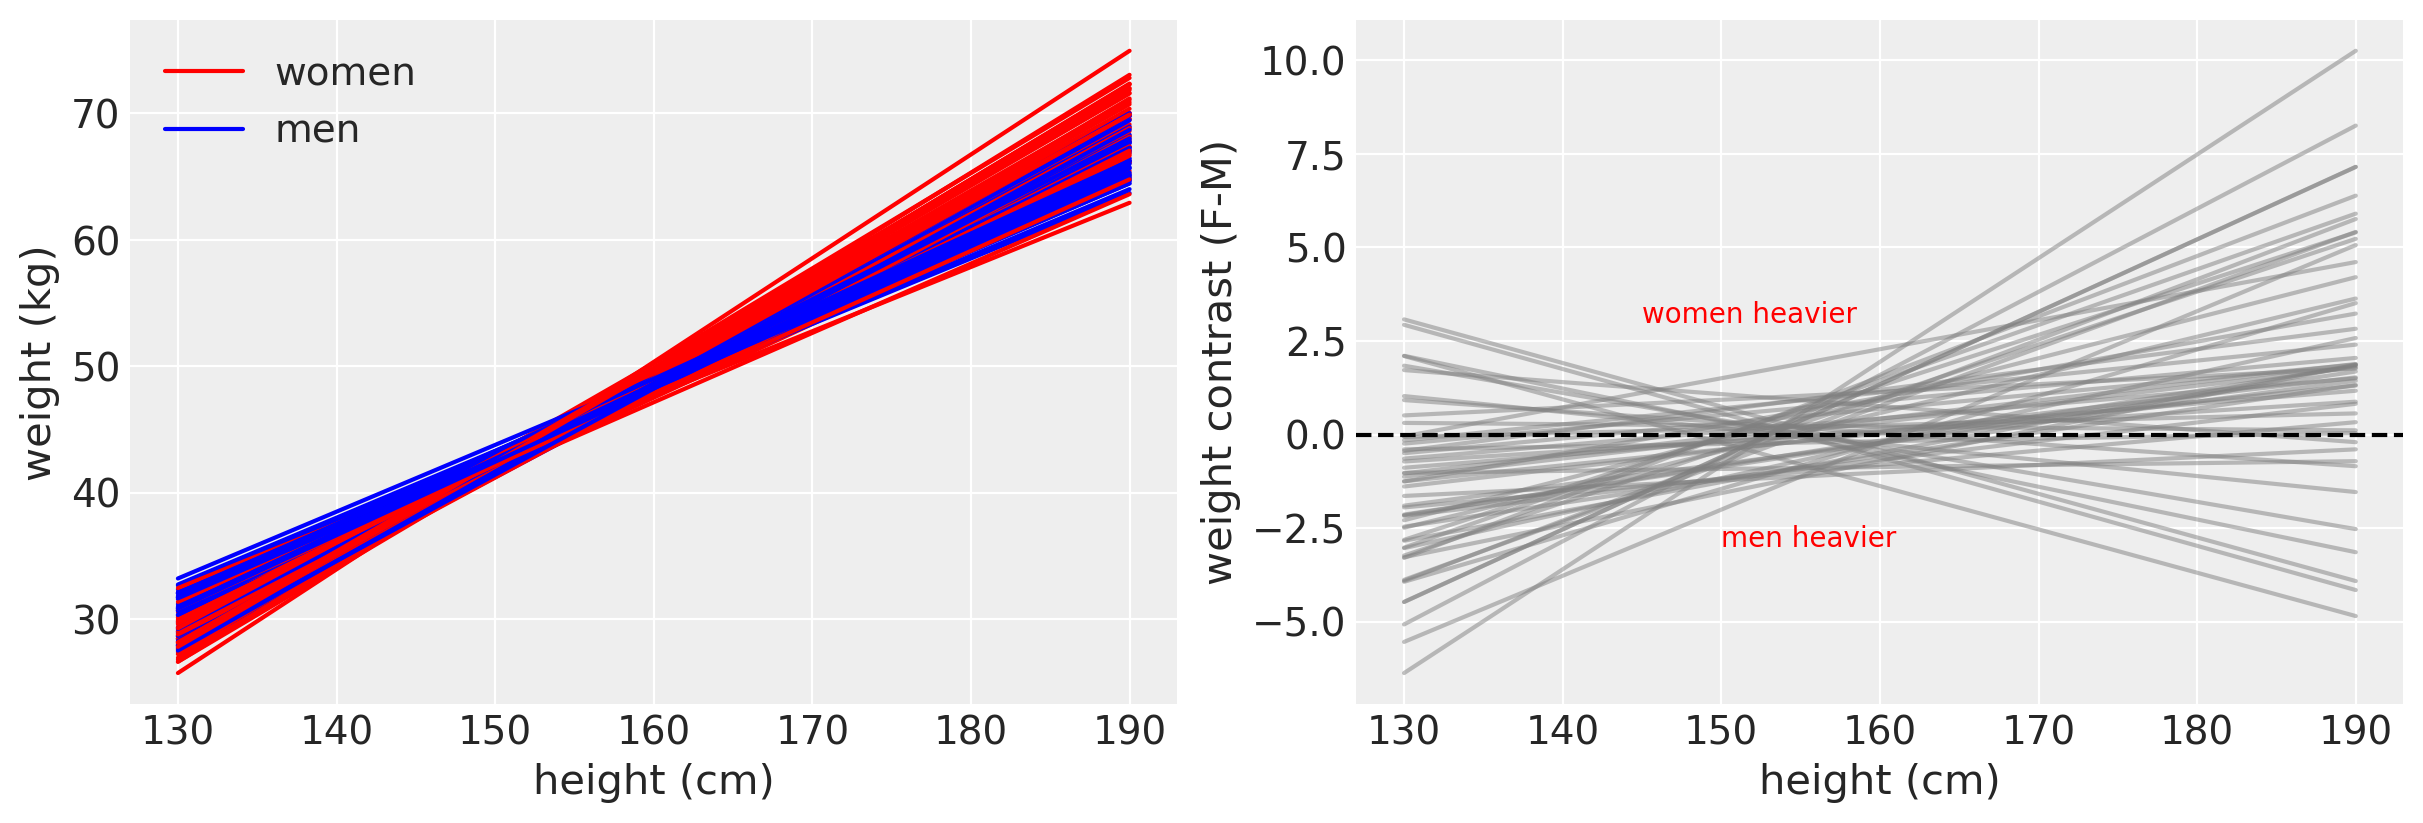

<IPython.core.display.Javascript object>

In [85]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

# These lines aren't shown in the slide
for i in range(50):

    if i == 0:
        ax0.plot(xseq, muF[i, :], color="red", label="women")
        ax0.plot(xseq, muM[i, :], color="blue", label="men")
    else:
        ax0.plot(xseq, muF[i, :], color="red")
        ax0.plot(xseq, muM[i, :], color="blue")
ax0.set(xlabel="height (cm)", ylabel="weight (kg)")
ax0.legend()

# Shade function on slide is from R rethinking package so it is not shown here
for i in range(50):
    ax1.plot(xseq, mu_contrast[i, :], color="gray", alpha=0.5)
ax1.set(xlabel="height (cm)", ylabel="weight contrast (F-M)")
ax1.axhline(y=0, linestyle="dashed", color="black")
ax1.text(150, -3, "men heavier", color="red")
ax1.text(145, 3, "women heavier", color="red")

# Slide 44

"One simulation for each estimand"

In [86]:
with pm.Model() as m_SHW_full:

    # weight -----------
    a = pm.Normal("a", 60, 10, shape=2)
    b = pm.Lognormal("b", 0, 1, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)
    mu = a[s_index] + b[s_index] * (heights - h_bar)  # linear model
    W = pm.Normal("W", mu, sigma, observed=weights)  # likelihood

    # height -----------
    h = pm.Normal("h", 160, 10, shape=2)
    tau = pm.Uniform("tau", 0, 10)
    nu = h[s_index]  # linear model
    H = pm.Normal("H", nu, tau, observed=heights)  # likelihood

    # posterior
    idata_m_SHW_full = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=True)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma, h, tau]
INFO:pymc:NUTS: [a, b, sigma, h, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


<IPython.core.display.Javascript object>

# Slide 46

In [89]:
az.summary(idata_m_SHW_full)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.166,0.449,44.403,45.830,0.007,0.005,4255.0,3521.0,1.0
a[1],45.100,0.470,44.326,45.813,0.007,0.005,4097.0,3107.0,1.0
h[0],149.531,0.405,148.887,150.187,0.006,0.004,5342.0,2979.0,1.0
h[1],160.358,0.431,159.659,161.037,0.006,0.004,5807.0,2703.0,1.0
b[0],0.657,0.063,0.564,0.764,0.001,0.001,4105.0,3091.0,1.0
b[1],0.609,0.056,0.520,0.699,0.001,0.001,3777.0,3071.0,1.0
sigma,4.268,0.162,4.021,4.533,0.002,0.002,5001.0,2918.0,1.0
tau,5.559,0.208,5.235,5.887,0.003,0.002,5714.0,3089.0,1.0


<IPython.core.display.Javascript object>

In [88]:
idata_m_SHW_full_df = idata_m_SHW_full.to_dataframe()
idata_m_SHW_full_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, h[0], 0)","(posterior, h[1], 1)","(posterior, b[0], 0)","(posterior, b[1], 1)","(posterior, sigma)","(posterior, tau)",...,"(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, lp)","(sample_stats, index_in_trajectory)","(sample_stats, energy_error)","(sample_stats, perf_counter_start)","(sample_stats, step_size)","(sample_stats, energy)","(sample_stats, largest_eigval)","(sample_stats, perf_counter_diff)"
0,0,0,45.820205,45.804320,149.767005,160.410099,0.742513,0.548267,4.099430,5.779971,...,False,-0.279789,-2132.210122,1,-0.217243,216064.834057,0.631081,2134.240626,NaN,0.001816
1,0,1,45.172606,45.538449,149.686060,160.673006,0.671513,0.522220,4.235396,5.064924,...,False,0.423809,-2133.011254,2,0.132907,216064.836085,0.631081,2136.334097,NaN,0.001822
2,0,2,45.542420,45.564708,149.677025,160.189689,0.701732,0.607492,4.341387,6.227783,...,False,0.254143,-2134.690551,4,0.254143,216064.838147,0.631081,2137.150054,NaN,0.002632
3,0,3,45.151058,45.365263,149.495297,159.848480,0.630274,0.470276,4.289531,5.884924,...,False,1.161552,-2135.319286,2,0.487472,216064.840997,0.631081,2140.394750,NaN,0.001922
4,0,4,45.485075,44.539216,149.608819,160.827875,0.706066,0.657738,4.230439,5.183100,...,False,-0.956284,-2131.461596,-5,-0.956284,216064.843113,0.631081,2136.325228,NaN,0.001962


<IPython.core.display.Javascript object>

# Slide 47

In [76]:
# n = 10**4

# simulate W for S=0
H_S0 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[("posterior", "h[0]", 0)],
    scale=idata_m_SHW_full_df[("posterior", "tau")],
    # size=n   (*see note below)
)

W_S0 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[("posterior", "a[0]", 0)]
    + idata_m_SHW_full_df[("posterior", "b[0]", 0)] * (H_S0 - h_bar),
    scale=idata_m_SHW_full_df[("posterior", "sigma")],
)

# simulate W for S=1
H_S1 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[("posterior", "h[1]", 1)],
    scale=idata_m_SHW_full_df[("posterior", "tau")],
    # size=n   (*see note below)
)

W_S1 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[("posterior", "a[1]", 1)]
    + idata_m_SHW_full_df[("posterior", "b[1]", 1)] * (H_S1 - h_bar),
    scale=idata_m_SHW_full_df[("posterior", "sigma")],
)

# compute contrast using full posterior distribution
W_do_S = W_S1 - W_S0

# *unlike in R, size has to be the same as the length of the vectors

<IPython.core.display.Javascript object>

In slides 47 and 48, he shows the posterior mean weight contrast in the left plot. However, the posterior mean weight are not explicitly calculated. But this is a reminder that the means of each group are themselves distributions, since they are the output of the alpha and beta parameters which are distributions. We get the posterior mean contrasts by taking the difference of these distributions. (Note that his plot appears more narrow. It's not clear to me why.)

It's also worth pointing out that the posterior mean weight contrast is using the posterior directly (not posterior predictive).

The plot on the right is using the posterior predictive (it's simulating observations) since we're using random draws and not using the posterior.

In [129]:
# compute contrast using mean only
W_S0_mean = idata_m_SHW_full_df[("posterior", "a[0]", 0)] + idata_m_SHW_full_df[
    ("posterior", "b[0]", 0)
] * (H_S0 - h_bar)

W_S1_mean = idata_m_SHW_full_df[("posterior", "a[1]", 1)] + idata_m_SHW_full_df[
    ("posterior", "b[1]", 1)
] * (H_S1 - h_bar)

W_do_S_mean = W_S1_mean - W_S0_mean

<IPython.core.display.Javascript object>

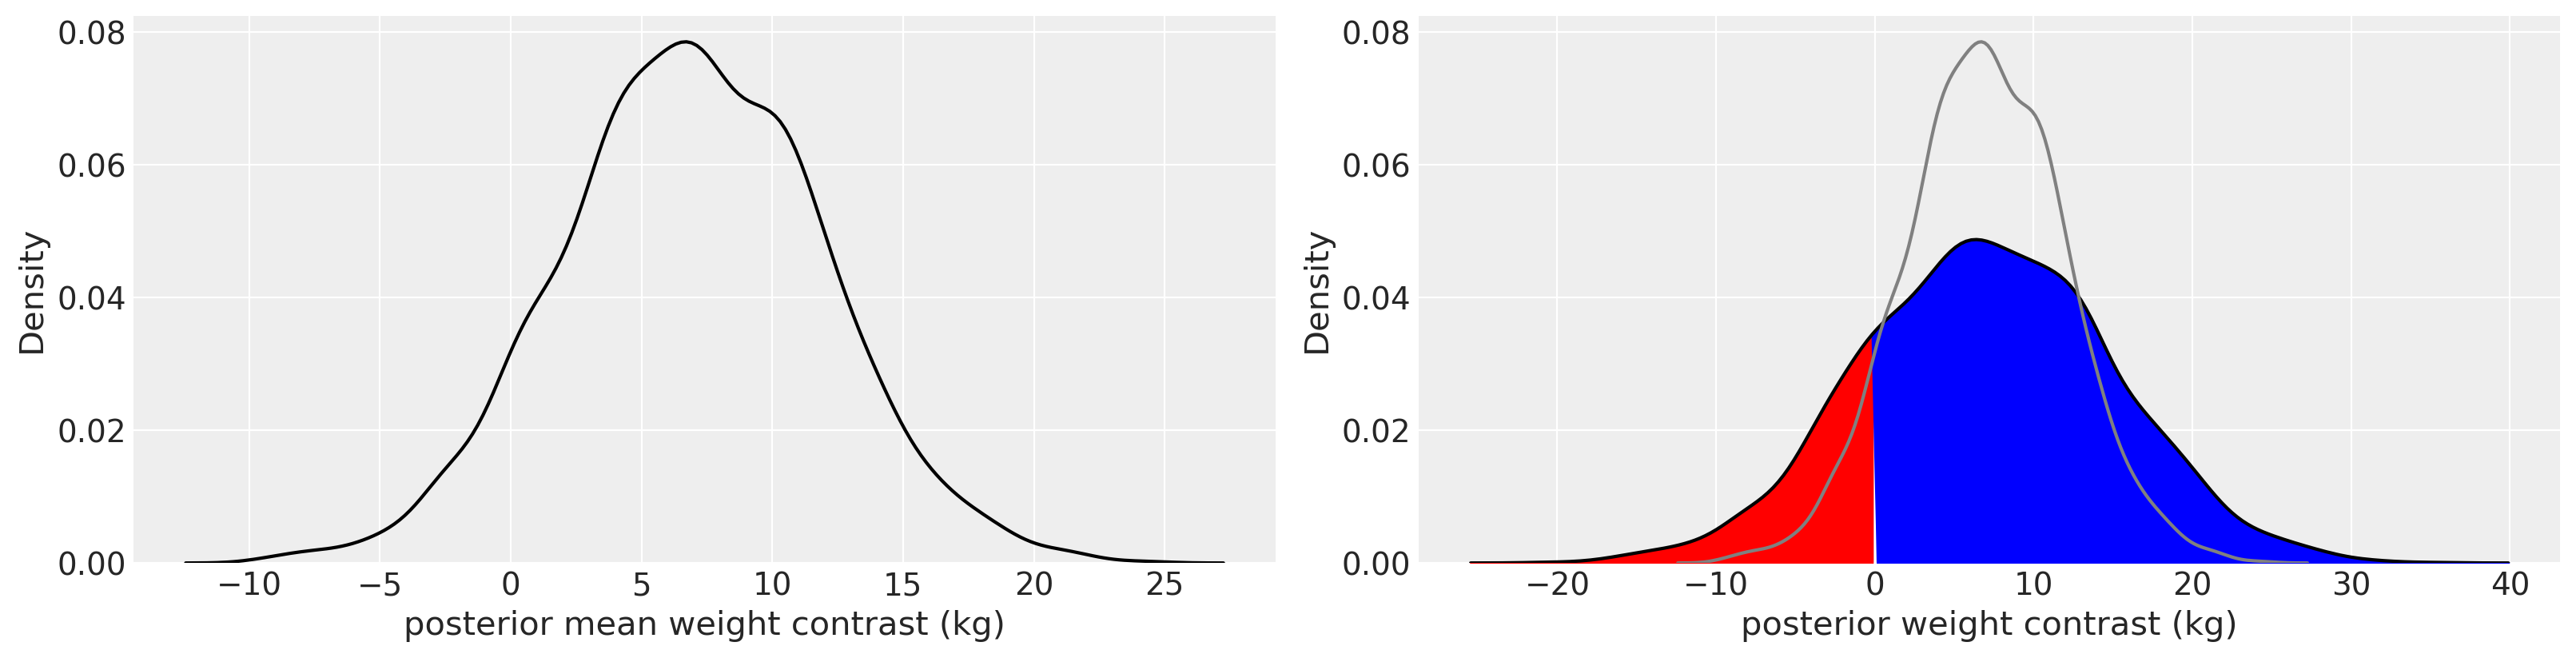

<IPython.core.display.Javascript object>

In [137]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))

# Plot of contrast using distribution of mean only  ---------
sns.kdeplot(W_do_S_mean, color="black", ax=ax0)
ax0.set(xlabel="posterior mean weight contrast (kg)")

# Plot of contrast using full posterior distribution ---------
ax1 = sns.kdeplot(W_do_S, color="black")  # , ax=ax0)
sns.kdeplot(W_do_S_mean, color="gray", ax=ax1)

ax1.set(xlabel="posterior weight contrast (kg)")
# Fill colors
kde_x, kde_y = ax1.lines[0].get_data()
ax1.fill_between(kde_x, kde_y, where=kde_x < 0, color="red", interpolate=True)
ax1.fill_between(kde_x, kde_y, where=kde_x > 0, color="blue", interpolate=True)

# Slide 48

The `sim` function is from the `rethinking` package. It essentially does what is described above.

# Credits

- Some code borrowed from [Chapter 4 repo](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_04.ipynb).
- Code for fill between from [Stack Overflow](https://stackoverflow.com/questions/46685453/how-to-fill-with-a-different-color-an-area-in-seaborn-distplot).

In [8]:
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sun Nov 13 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

aesara: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

scipy     : 1.9.0
pymc      : 4.1.7
arviz     : 0.12.1
numpy     : 1.23.2
pandas    : 1.4.3
seaborn   : 0.12.1
matplotlib: 3.5.3
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:43:44) [Clang 13.0.1 ]

Watermark: 2.3.1

